In [1]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1011. Emission Mixtures/P1011.3. Analyses/P1011.3.2. Biomarker Cluster Analysis/Output')
cur_date = "042123"

library(readxl)
library(tidyverse)
library(reshape2)
library(factoextra)

# reading in files
#mRNA_df = data.frame(read_excel("Input/mRNA_Data_041423.xlsx", sheet = 2))
proteomics_5_df = data.frame(read_excel("Input/Proteomics_Data_5ug_040423.xlsx", sheet = 2))
proteomics_25_df = data.frame(read_excel("Input/Proteomics_Data_25ug_040423.xlsx", sheet = 2))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



In [2]:
#head(mRNA_df)
head(proteomics_25_df)

,Subject_No,Subject_ID,Protein_Accession,Gene_Name,Description,Condensate,Burn_Condition,Concentration,Intensity,Intensity_pslog2
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,1,F_1,CO3_HUMAN,C3,Complement C3 OS=Homo sapiens OX=9606 GN=C3 PE=1 SV=2,C,F,25,1488600000,30.47131
2,2,M_2,CO3_HUMAN,C3,Complement C3 OS=Homo sapiens OX=9606 GN=C3 PE=1 SV=2,C,F,25,3806600000,31.82586
3,3,M_3,CO3_HUMAN,C3,Complement C3 OS=Homo sapiens OX=9606 GN=C3 PE=1 SV=2,C,F,25,3900000000,31.86083
4,4,F_4,CO3_HUMAN,C3,Complement C3 OS=Homo sapiens OX=9606 GN=C3 PE=1 SV=2,C,F,25,5373200000,32.32313
5,5,F_5,CO3_HUMAN,C3,Complement C3 OS=Homo sapiens OX=9606 GN=C3 PE=1 SV=2,C,F,25,2595200000,31.27320
6,6,M_6,CO3_HUMAN,C3,Complement C3 OS=Homo sapiens OX=9606 GN=C3 PE=1 SV=2,C,F,25,5780700000,32.42860


This analysis will use PCA & k means to explore to determine if each biomarker clusters into groups.

In [3]:
wider_proteomics_25_df = proteomics_25_df %>%
    # creating a column that denotes the biomarker
    mutate(Biomarker = "Protein") %>%
    # creating sample ids
    unite("Sample_ID", c(colnames(proteomics_25_df)[c(3,6:8)])) %>%
    select(-colnames(proteomics_25_df)[c(1,4,5,9)]) %>%
    pivot_wider(names_from = "Subject_ID", values_from = "Intensity_pslog2")

wider_proteomics_5_df = proteomics_5_df %>%
    # creating a column that denotes the biomarker
    mutate(Biomarker = "Protein") %>%
    # creating sample ids
    unite("Sample_ID", c(colnames(proteomics_5_df)[c(3,6:8)])) %>%
    select(-colnames(proteomics_5_df)[c(1,4,5,9)]) %>%
    pivot_wider(names_from = "Subject_ID", values_from = "Intensity_pslog2")

# creating 1 df
wider_proteomics_df = rbind(wider_proteomics_25_df, wider_proteomics_5_df) %>%
    column_to_rownames(var = "Sample_ID") 
head(wider_proteomics_df)

,Biomarker,F_1,M_2,M_3,F_4,F_5,M_6
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CO3_HUMAN_C_F_25,Protein,30.47131,31.82586,31.86083,32.32313,31.27320,32.42860
CO3_HUMAN_C_S_25,Protein,31.95699,31.17766,32.27534,33.11253,31.32839,31.60576
CO3_HUMAN_PBS_PBS_25,Protein,28.35565,30.75581,31.88987,32.22239,31.53371,33.69975
CO3_HUMAN_P_F_25,Protein,31.09012,31.49596,32.07058,33.27462,31.81062,32.34631
CO3_HUMAN_P_S_25,Protein,31.06664,31.42337,32.18299,33.80097,31.79819,33.90464
K1C19_HUMAN_C_F_25,Protein,32.48738,34.19938,31.95404,32.58571,32.79860,31.79231


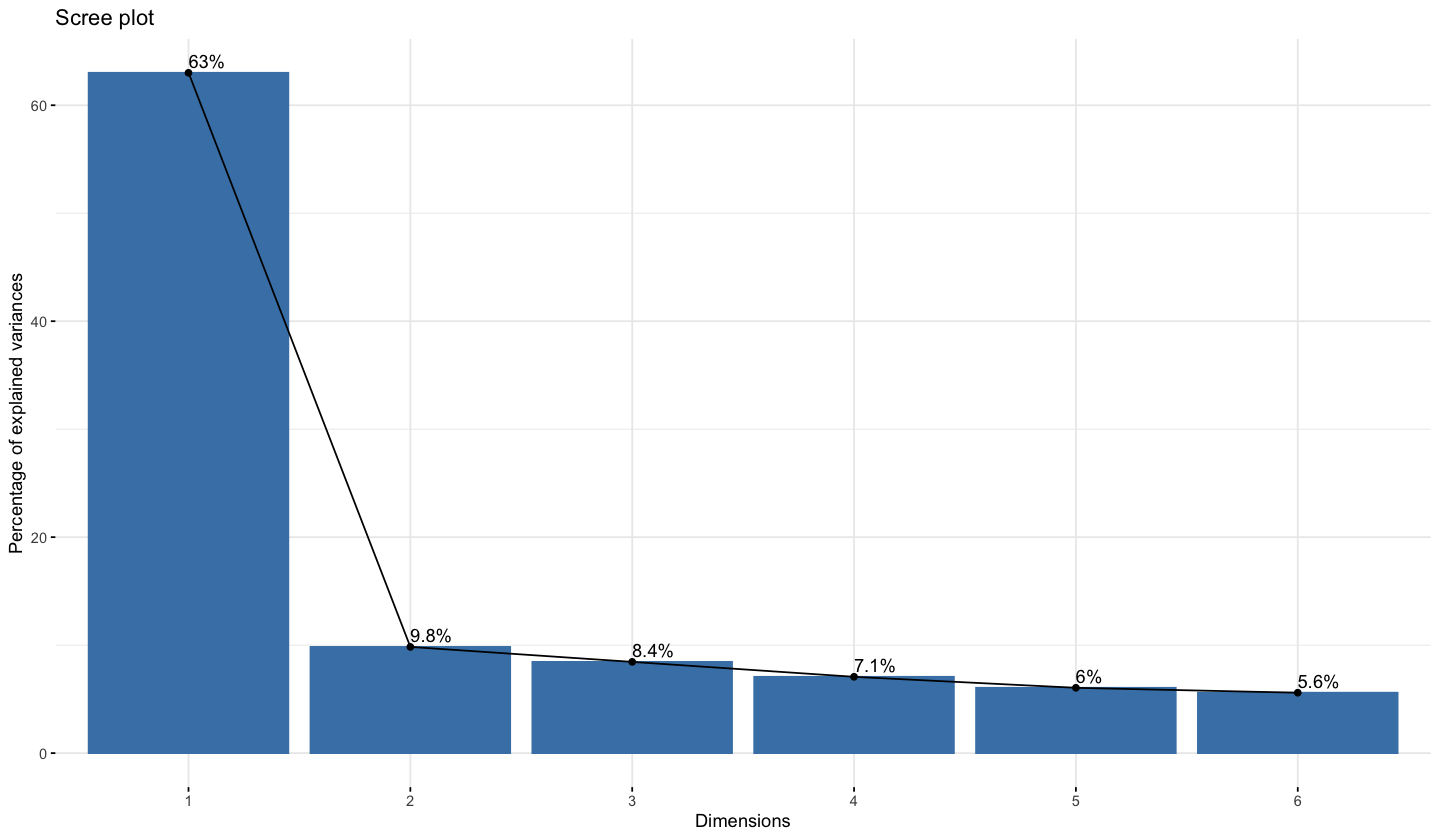

In [4]:
# running pca 
pca_all_data = prcomp(wider_proteomics_df[,2:7], center = TRUE)

# looking a scree plot to see how much of the variance was captured in first 2 eigenvectors
options(repr.plot.width = 12, repr.plot.height = 7) #changing size
fviz_eig(pca_all_data, addlabels = TRUE)

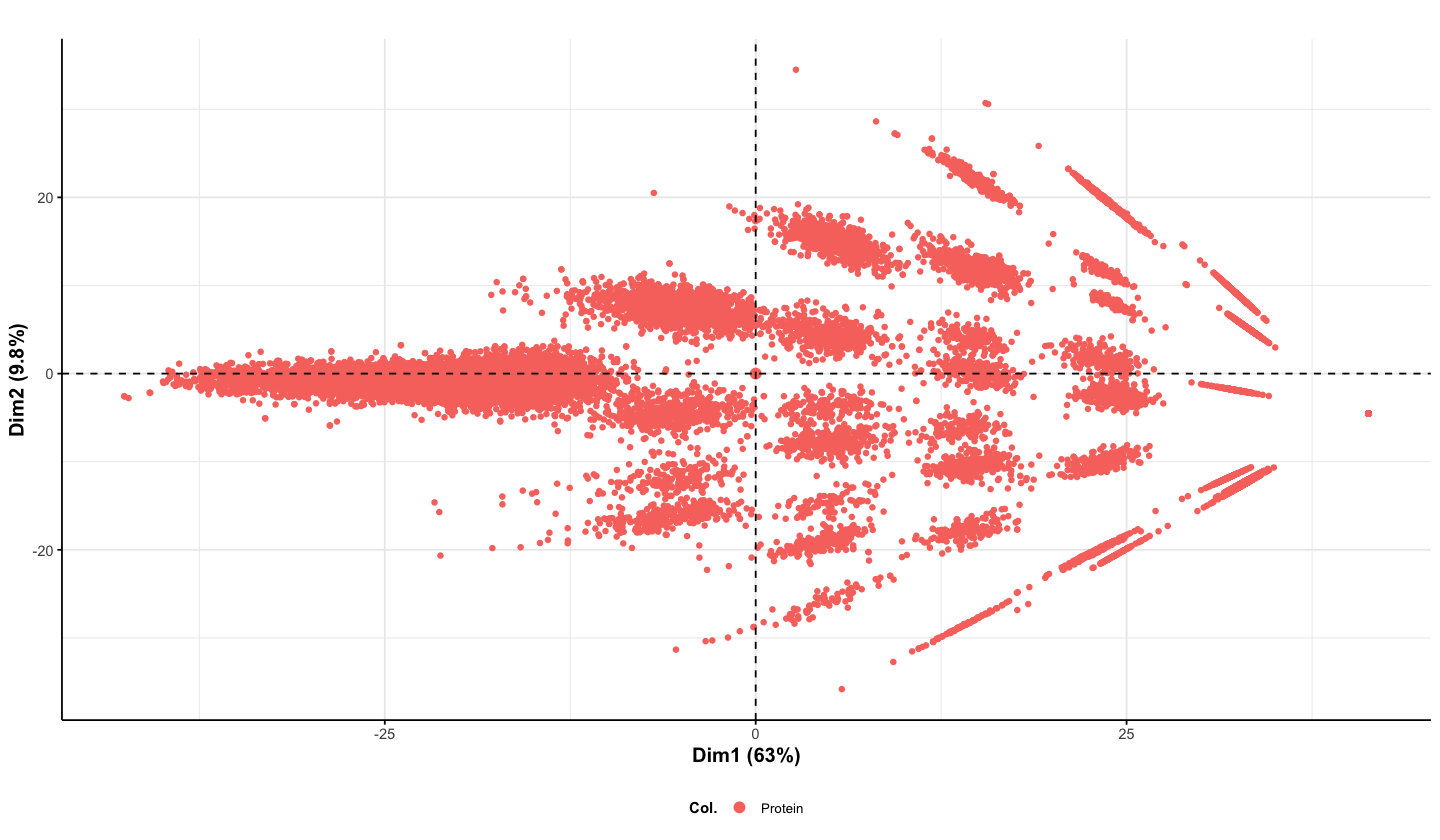

In [5]:
# visualizing all data to detect outlier subjects
options(repr.plot.width = 12, repr.plot.height = 7) # changing size
fviz_pca_ind(pca_all_data, geom.ind = "point", # removes geo ids
             # coloring by biomarker
             col.ind = factor(as.character(wider_proteomics_df$Biomarker)), 
#              #adding 95% confidence ellipses for each group
#              addEllipses = TRUE, # Concentration ellipses
#              ellipse.type = "confidence", # now making them concentration ellipses
             repel = TRUE, title = "") +
theme(axis.line = element_line(colour = "black"), # making x and y axes black
      legend.title = element_text(size = 9, face = "bold"),
      legend.text = element_text(size = 8),
      legend.position = 'bottom',
      axis.title = element_text(face = "bold", size = rel(1.1))) # changes axis titles